In [1]:
import ray
import os
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost_ray import RayDMatrix, RayParams, train, RayXGBRFClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, f1_score, classification_report

In [2]:
ray.shutdown()
ray.init()

2022-12-09 14:19:34,857	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,2.1.0
Dashboard:,http://127.0.0.1:8265


**Read dataset**

In [3]:
df=pd.read_csv("gs://bucketbigdataman/dataset/Australia1.csv")

In [4]:
print(df.head())
seed=42

   MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     13.4     22.9       0.6     5.472516       8.5           44.0   
1      7.4     25.1       0.0     5.472516       8.5           44.0   
2     12.9     25.7       0.0     5.472516       8.5           46.0   
3      9.2     28.0       0.0     5.472516       8.5           24.0   
4     17.5     32.3       1.0     5.472516       8.5           41.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  WindDir3pm_NNW  \
0          20.0          24.0         71.0         22.0  ...               0   
1           4.0          22.0         44.0         25.0  ...               0   
2          19.0          26.0         38.0         30.0  ...               0   
3          11.0           9.0         45.0         16.0  ...               0   
4           7.0          20.0         82.0         33.0  ...               0   

   WindDir3pm_NW  WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  \
0          

**Split dataset**

In [5]:
X = df.drop(['RainTomorrow'], axis=1)
t = df['RainTomorrow']

In [6]:
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.75)
print(t_test.head())

108785    1.0
25044     0.0
24362     0.0
77174     0.0
22473     0.0
Name: RainTomorrow, dtype: float64


In [7]:
start_time=time.time()

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Set parameters**

In [9]:
ray_param = RayParams(
                      num_actors=4,
                      cpus_per_actor=4
                   ) 

**Model selection**

In [10]:
model = RayXGBRFClassifier(n_jobs=4,
                           random_state=seed)

In [11]:
param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
             'min_child_weight': np.arange(0.0001, 0.5, 0.001),
             'gamma': np.arange(0.0,40.0,0.005),
             'learning_rate': np.arange(0.0005,0.3,0.0005),
             'subsample': np.arange(0.01,1.0,0.01),
             'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
             'colsample_bytree': np.arange(0.1,1.0,0.01)
            } 

In [12]:
#grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring="f1")
#grid_result = grid_search.fit(X_train,t_train)

In [13]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

**Training**

In [14]:
model = RayXGBRFClassifier(n_jobs=4,
                           random_state=seed,
                           subsample=0.91, 
                           min_child_weight= 0.3311,
                           max_depth=10,
                           learning_rate= 0.1745, 
                           gamma=38.385, 
                           colsample_bytree=0.7599999999999996,
                           colsample_bylevel=1.0)

In [15]:
model.fit(X_train,t_train, ray_params=ray_param)

/opt/conda/miniconda3/lib/python3.8/site-packages/xgboost_ray/sklearn.py:307: UserWarning: `ray_params` is not `None` and will override the `n_jobs` attribute.
  warnings.warn("`ray_params` is not `None` and will override "
2022-12-09 14:19:43,142	INFO main.py:1035 -- [RayXGBoost] Created 4 new actors (4 total actors). Waiting until actors are ready for training.
2022-12-09 14:19:45,061	INFO main.py:1080 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=23796) [14:19:45] task [xgboost.ray]:139829775008144 got new rank 0
(_RemoteRayXGBoostActor pid=23797) [14:19:45] task [xgboost.ray]:140138376360336 got new rank 1
(_RemoteRayXGBoostActor pid=23805) [14:19:45] task [xgboost.ray]:140409515520400 got new rank 3
(_RemoteRayXGBoostActor pid=23804) [14:19:45] task [xgboost.ray]:139831148736912 got new rank 2
2022-12-09 14:19:55,020	INFO main.py:1575 -- [RayXGBoost] Finished XGBoost training on training data with total N=104,904 in 12.10 seconds (9.95 pure XGBoost trainin

RayXGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                   colsample_bylevel=1.0, colsample_bytree=0.7599999999999996,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=38.385,
                   gpu_id=-1, grow_policy='depthwise', importance_type=None,
                   interaction_constraints='', learning_rate=0.1745,
                   max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
                   max_delta_step=0, max_depth=10, max_leaves=0,
                   min_child_weight=0.3311, missing=nan,
                   monotone_constraints='()', n_estimators=100, n_jobs=4,
                   num_parallel_tree=100, objective='binary:logistic',
                   predictor='auto', random_state=42, ...)

**Test**

In [16]:
t_hat=model.predict(X_test)

2022-12-09 14:19:55,068	INFO main.py:1620 -- [RayXGBoost] Created 4 remote actors.
2022-12-09 14:19:56,874	INFO main.py:1637 -- [RayXGBoost] Starting XGBoost prediction.


In [17]:
t_hat_score = model.predict_proba(X_test)

2022-12-09 14:19:56,964	INFO main.py:1620 -- [RayXGBoost] Created 4 remote actors.
2022-12-09 14:19:58,794	INFO main.py:1637 -- [RayXGBoost] Starting XGBoost prediction.


**Model evaluation**

In [18]:
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(t_test, t_hat)))
print(classification_report(t_test,t_hat))

Test-set accuracy score: 0.8429
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     27350
         1.0       0.74      0.43      0.54      7618

    accuracy                           0.84     34968
   macro avg       0.80      0.69      0.72     34968
weighted avg       0.83      0.84      0.83     34968



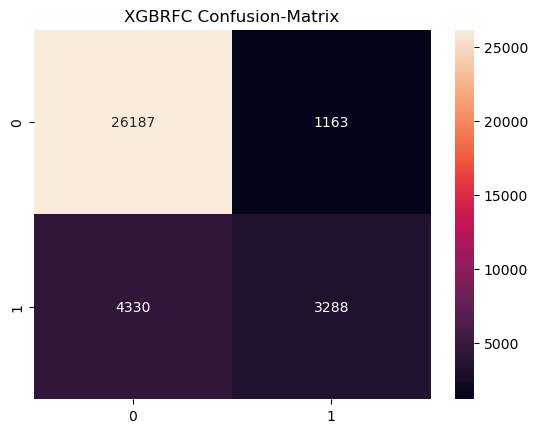

In [19]:
ax = plt.axes()
cm = confusion_matrix(t_test, t_hat)
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_title('XGBRFC Confusion-Matrix')
plt.show()

In [20]:
print(time.time()-start_time)

16.60193943977356
